In [1]:
import pandas as pd
import numpy as np
import torch

from collections import namedtuple
from itertools import chain
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
users = pd.read_csv("data/up-selling/peotv/peoTV_user_content.csv")
ratings = pd.read_csv("data/up-selling/peotv/azure/peoTV_user_ratings.csv")
packages = pd.read_csv("data/up-selling/peotv/peoTV_package_content.csv")

In [3]:
USER_COLUMNS = [ "ACCOUNT_NUM.hash", "Voice_INCOMING_Scaled", 
            "Location_Identifier", "Location_Node",  "Package_Type_and_Medium", "Model", "Service_Status",
            "Voice_OUTGOING_Scaled", "IDD_INCOMING_Scaled", "IDD_incoming_country",
            "IDD_OUTGOING_Scaled", "IDD_outgoing_country", "BB_Scaled", "BB_Package", "GENDER", "AGE",
            "Subscription", "Sub_Type", "Sub_Usage", "Sub_Type_State", "Megaline_Package", 
            "Megaline_Medium", "Megaline_Rental_Scaled", "FTTH_Package",
            "FTTH_Month_Subscribed", "FTTH_Medium", "FTTH_Rental_Scaled", "LTE_Package", "LTE_Medium","LTE_Rental_Scaled",
            "VAS_Package", "Product_Type", "VAS_Medium", "VAS_Rental_Scaled", "Sub_Update_Status", "Sub_Update",
            "BB_Extra_GB_Amount", "BB_Extra_GB_Hour_Subscribed", "BB_Extra_GB_Usage_Times",
            "BB_Extra_GB_Purchased_Scaled", "BB_Extra_GB_Subscribed_Night" ,"BB_Extra_GB_Subscribed_Day",
            "BB_Extra_GB_Rental_Scaled", "Peo_Extra_Channels_Cumulative_Rental", "Peo_Extra_Channels_Purchased_Scaled",
            "Peo_Extra_Channels_Purchased_Categorical", "Bill_Outstanding_Balance", "Bill_Billing_Status",
            "Payment_Status", "Package_Formatted", "TARIFF_DESC", "TARIFF_NAME", "Having_Insurance",
            "Having_Senior_Citizen_Scaled","Having_Kids_at_Home_Scaled","SMEs_Scaled",
            "Having_Teenagers_Students_Scaled","Having_Working_Professionals_Scaled","Having_Family_Member_Abroad_Scaled",
            "Tamil_Customer"]

PACKAGE_COLUMNS = ["package", 'Title', 'Price', 'Monthly_Rental',
            'PEOTV_No_of_Channels', 'PEOTV_Foreign_Channels','PEOTV_Local_Channels', 'PEOTV_Movie_Channels', 
            'PEOTV_Kids_Channels','PEOTV_Religious_Channels', 'PEOTV_Tamil_Channels','PEOTV_Educational_Channels', 
            'PEOTV_Music_Channels','PEOTV_Sports_Channels', 'PEOTV_News_Channels', 'PEOTV_HD_Pack']

LABEL_COLUMN = "package"
USER_COULMN = "user"
RATING_COLUMN = "ratings"
OUTLIER_COLUMNS = ["Voice_INCOMING_Outlier","Voice_OUTGOING_Outlier"]

Functions for Pre Processing

In [4]:
# one hot encoder
def oneHotEncoder(array_1d):
    label = LabelEncoder().fit_transform(array_1d)
    label = label.reshape(len(label), 1)
    one_hot = OneHotEncoder(sparse=False).fit_transform(label)
    return one_hot

# min-max scaler
def minMaxScale(array_2d):
    return MinMaxScaler().fit_transform(array_2d)

# Turkey's box-plot method to clip outliers
def outliers(s, replace=np.nan):
    Q1, Q3 = np.percentile(s, [25 ,75])
    IQR = Q3-Q1
    return s.where((s > (Q1 - 1.5 * IQR)) & (s < (Q3 + 1.5 * IQR)), replace)

# clip outliers
def drop_numerical_outliers(df, cols):
  df[cols] = df[cols].apply(outliers)
  return df

# handle pre-defined outliers
def handle_outliers(df, cols):
  for col in cols:
    df = df[(df[col] != "YES")]
  return df

# drop unwanted cols
def drop_cols(df, columns):
  cols_to_drop = []
  for col in columns:
    if col not in df.columns:
      cols_to_drop.append(col)
  return df.drop(cols_to_drop, axis=1)

## Data Pre processing

In [5]:
try:
  users.drop(["Unnamed: 0"], axis=1, inplace=True)
  ratings.drop(["Unnamed: 0"], axis=1, inplace=True)
  packages.drop(["Unnamed: 0"], axis=1, inplace=True)
except:
  pass

# func to define labels based on most rated items
# user_ratings[RANK_COLUMN] = user_ratings.groupby("ACCOUNT_NUM.hash")['ratings'].rank(method='first', ascending=False)

# drop unused columns for analysis
users.drop(columns=[col for col in users if col not in USER_COLUMNS], inplace=True)
packages.drop(columns=[col for col in packages if col not in PACKAGE_COLUMNS], inplace=True)

users.rename(columns={"ACCOUNT_NUM.hash":USER_COULMN},inplace=True)
ratings.rename(columns={"ACCOUNT_NUM.hash":USER_COULMN},inplace=True)
ratings.sort_values(by=[USER_COULMN,RATING_COLUMN],inplace=True,ascending=False)

In [6]:
#Data quality
print('Duplicated rows in ratings file: ' + str(ratings.duplicated().sum()))

n_users = ratings[USER_COULMN].unique().shape[0]
n_packages = ratings[LABEL_COLUMN].unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of packages: {}'.format(n_packages))
print('Sparsity: {:4.3f}%'.format(float(ratings.shape[0]) / float(n_users*n_packages) * 100))

Duplicated rows in ratings file: 70144
Number of users: 19019
Number of packages: 49
Sparsity: 17.106%


In [7]:
rating_package = pd.merge(ratings,packages,how='left',on=LABEL_COLUMN)

In [8]:
final_df = pd.merge(rating_package,users,how='left',on=USER_COULMN)

## Feature Selection

In [9]:
le_data = final_df.copy()

ALL_COLUMNS = list(le_data.columns)
ALL_COLUMNS.remove(LABEL_COLUMN)
ALL_COLUMNS.remove(USER_COULMN)
CONTINUOUS_COLUMNS = list(le_data._get_numeric_data().columns)
CONTINUOUS_COLUMNS.remove(RATING_COLUMN)
CATEGORICAL_COLUMNS = list(set(ALL_COLUMNS) - set(CONTINUOUS_COLUMNS))

for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    le_data[c] = le.fit_transform(final_df[c])

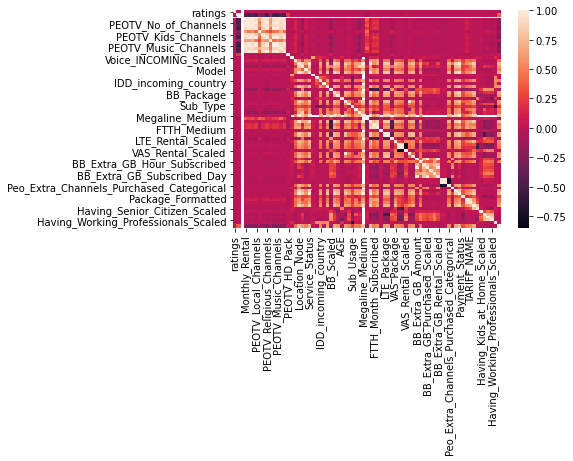

In [10]:
cor_df = le_data.drop(columns=[col for col in le_data if col not in ALL_COLUMNS])
corr = cor_df.corr()
sns.heatmap(corr)

In [11]:
# select columns (selected features)
cols = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if cols[j]:
                cols[j] = False

selected_columns = cor_df.columns[cols]
print("Selected Columns", selected_columns)
print("\nSelected no of columns", len(selected_columns))

# final dataframe to merge model predictions
le_data = le_data[[USER_COULMN,LABEL_COLUMN,RATING_COLUMN] + list(selected_columns)]

# for column list generation
data = final_df[[USER_COULMN,LABEL_COLUMN,RATING_COLUMN] + list(selected_columns)]

Selected Columns Index(['ratings', 'Title', 'Price', 'Monthly_Rental', 'PEOTV_Movie_Channels',
       'PEOTV_Tamil_Channels', 'PEOTV_HD_Pack', 'Voice_INCOMING_Scaled',
       'Location_Identifier', 'Location_Node', 'Package_Type_and_Medium',
       'Model', 'Voice_OUTGOING_Scaled', 'IDD_INCOMING_Scaled',
       'IDD_incoming_country', 'IDD_OUTGOING_Scaled', 'IDD_outgoing_country',
       'BB_Scaled', 'GENDER', 'AGE', 'Subscription', 'Sub_Type', 'Sub_Usage',
       'Sub_Type_State', 'Megaline_Package', 'Megaline_Rental_Scaled',
       'FTTH_Month_Subscribed', 'FTTH_Rental_Scaled', 'LTE_Package',
       'LTE_Rental_Scaled', 'VAS_Package', 'Product_Type', 'VAS_Rental_Scaled',
       'Sub_Update', 'BB_Extra_GB_Amount', 'BB_Extra_GB_Hour_Subscribed',
       'BB_Extra_GB_Usage_Times', 'BB_Extra_GB_Subscribed_Night',
       'BB_Extra_GB_Subscribed_Day', 'Peo_Extra_Channels_Cumulative_Rental',
       'Peo_Extra_Channels_Purchased_Categorical', 'Bill_Outstanding_Balance',
       'Bill_Billing_S

In [12]:
# resetting parameters for selected features
ALL_COLUMNS = list(data.columns)
ALL_COLUMNS.remove(LABEL_COLUMN)
ALL_COLUMNS.remove(USER_COULMN)
CONTINUOUS_COLUMNS = list(data._get_numeric_data().columns)
CONTINUOUS_COLUMNS.remove(RATING_COLUMN)
CATEGORICAL_COLUMNS = list(set(ALL_COLUMNS) - set(CONTINUOUS_COLUMNS))

## Encoding and Data Processing

In [13]:
# encoder function
def encoder(df, cols=None):
    if cols == None:
        cols = list(df.select_dtypes(include=['object']).columns)

    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x])

    return val_to_idx, df

In [14]:
#function to test train splitting of data with embedding
def data_processing(df, wide_cols, embeddings_cols, continuous_cols, target,
    scale=False, def_dim=8):


    if type(embeddings_cols[0]) is tuple:
        emb_dim = dict(embeddings_cols)
        embeddings_cols = [emb[0] for emb in embeddings_cols]
    else:
        emb_dim = {e:def_dim for e in embeddings_cols}
    deep_cols = embeddings_cols+continuous_cols

    # Extract the target and copy the dataframe so we don't mutate it
    # internally.
    Y = np.array(df[target])
    all_columns = list(set(wide_cols + deep_cols ))
    df_tmp = df.copy()[all_columns]


    # Extract the categorical column names that can be one hot encoded later
    categorical_columns = list(df_tmp.select_dtypes(include=['object']).columns)

    
    encoding_dict,df_tmp = encoder(df_tmp)
    encoding_dict = {k:encoding_dict[k] for k in encoding_dict if k in deep_cols}
    embeddings_input = []
    for k,v in encoding_dict.items():
        embeddings_input.append((k, len(v), emb_dim[k]))

    df_deep = df_tmp[deep_cols]
    deep_column_idx = {k:v for v,k in enumerate(df_deep.columns)}


    if scale:
        scaler = StandardScaler()
        for cc in continuous_cols:
            df_deep[cc]  = scaler.fit_transform(df_deep[cc].values.reshape(-1,1))

    df_wide = df_tmp[wide_cols]
    del(df_tmp)
    dummy_cols = [c for c in wide_cols if c in categorical_columns]
    df_wide = pd.get_dummies(df_wide, columns=dummy_cols)

    X_train_deep, X_test_deep = train_test_split(df_deep.values, test_size=0.3, random_state=1463)
    X_train_wide, X_test_wide = train_test_split(df_wide.values, test_size=0.3, random_state=1463)
    y_train, y_test = train_test_split(Y, test_size=0.3, random_state=1981)

    group_dataset = dict()
    train_dataset = namedtuple('train_dataset', 'wide, deep, labels')
    test_dataset  = namedtuple('test_dataset' , 'wide, deep, labels')
    group_dataset['train_dataset'] = train_dataset(X_train_wide, X_train_deep, y_train)
    group_dataset['test_dataset']  = test_dataset(X_test_wide, X_test_deep, y_test)
    group_dataset['embeddings_input']  = embeddings_input
    group_dataset['deep_column_idx'] = deep_column_idx
    group_dataset['encoding_dict'] = encoding_dict

    return group_dataset


In [15]:
# Define embedding sizes for categorical cols
def categorical_embedding(data,cat_cols):
  tup_col = []
  for col in cat_cols:
    ulen = len(data[col].unique())
    if ulen > 100:
      ulen = 20
    elif ulen > 50:
      ulen = 10
    else:
      ulen = 5
    tup_col.append((col,ulen))
  return tup_col

PyTorch Wide and Deep Model

In [16]:
#class to load the dataset
class DatasetLoader(Dataset):
    def __init__(self, data):

        self.X_wide = data.wide
        self.X_deep = data.deep
        self.Y = data.labels

    def __getitem__(self, idx):

        xw = self.X_wide[idx]
        xd = self.X_deep[idx]
        y  = self.Y[idx]

        return xw, xd, y

    def __len__(self):
        return len(self.Y)


In [17]:
#class defining the wide and deep neural network
class WideandDeepNet(nn.Module):

    def __init__(self,
                 wide_dim,
                 embeddings_input,
                 continuous_cols,
                 deep_column_idx,
                 hidden_layers,
                 dropout,
                 encoding_dict,
                 n_class):

        super(WideandDeepNet, self).__init__()
        self.wide_dim = wide_dim
        self.deep_column_idx = deep_column_idx
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.encoding_dict = encoding_dict
        self.n_class = n_class
        self.loss_values=[]

        # Build the embedding layers to be passed through the deep-side
        for col,val,dim in self.embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))

        # Build the deep-side hidden layers with dropout if specified
        input_emb_dim = np.sum([emb[2] for emb in self.embeddings_input])
        self.linear_1 = nn.Linear(input_emb_dim+len(continuous_cols), self.hidden_layers[0])
        if self.dropout:
            self.linear_1_drop = nn.Dropout(self.dropout[0])
        for i,h in enumerate(self.hidden_layers[1:],1):
            setattr(self, 'linear_'+str(i+1), nn.Linear( self.hidden_layers[i-1], self.hidden_layers[i] ))
            if self.dropout:
                setattr(self, 'linear_'+str(i+1)+'_drop', nn.Dropout(self.dropout[i]))

        # Connect the wide- and dee-side of the model to the output neuron(s)
        self.output = nn.Linear(self.hidden_layers[-1]+self.wide_dim, self.n_class)


    def compile(self, optimizer="Adam", learning_rate=0.001, momentum=0.0):        
        self.activation, self.criterion = None, F.mse_loss

        if optimizer == "Adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        if optimizer == "RMSprop":
            self.optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate)
        if optimizer == "SGD":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)

        self.method = 'regression'


    def forward(self, X_w, X_d):
        # Deep Side
        emb = [getattr(self, 'emb_layer_'+col)(X_d[:,self.deep_column_idx[col]].long())
               for col,_,_ in self.embeddings_input]
        if self.continuous_cols:
            cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
            cont = [X_d[:, cont_idx].float()]
            deep_inp = torch.cat(emb+cont, 1)
        else:
            deep_inp = torch.cat(emb, 1)

        x_deep = F.relu(self.linear_1(deep_inp))
        if self.dropout:
            x_deep = self.linear_1_drop(x_deep)
        for i in range(1,len(self.hidden_layers)):
            x_deep = F.relu( getattr(self, 'linear_'+str(i+1))(x_deep) )
            if self.dropout:
                x_deep = getattr(self, 'linear_'+str(i+1)+'_drop')(x_deep)

        # Deep + Wide sides
        wide_deep_input = torch.cat([x_deep, X_w.float()], 1)

        if not self.activation:
            out = self.output(wide_deep_input)
        else:
            out = self.activation(self.output(wide_deep_input))

        return out


    def fit(self, dataset, n_epochs, batch_size):
        widedeep_dataset = DatasetLoader(dataset)
        train_loader = torch.utils.data.DataLoader(dataset=widedeep_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True)

        # set the model in training mode
        net = self.train()
        for epoch in range(n_epochs):
            total=0
            correct=0
            for i, (X_wide, X_deep, target) in enumerate(train_loader):
                X_w = Variable(X_wide)
                X_d = Variable(X_deep)
                y = (Variable(target).float() if self.method != 'multiclass' else Variable(target))

                if use_cuda:
                    X_w, X_d, y = X_w.cuda(), X_d.cuda(), y.cuda()

                self.optimizer.zero_grad()
                y_pred =  net(X_w, X_d)
                y_pred = torch.squeeze(y_pred)
                loss = self.criterion(y_pred, y)
                loss.backward()
                self.optimizer.step()

                if self.method != "regression":
                    total+= y.size(0)
                    if self.method == 'logistic':
                        y_pred_cat = (y_pred > 0.5).squeeze(1).float()
                    if self.method == "multiclass":
                        _, y_pred_cat = torch.max(y_pred, 1)
                    correct+= float((y_pred_cat == y).sum().data[0])
            self.loss_values.append(loss.item())
            print ('Epoch {} of {}, Loss: {}'.format(epoch+1, n_epochs,
                    round(loss.item(),3)))


    def predict(self, dataset):
        X_w = Variable(torch.from_numpy(dataset.wide)).float()
        X_d = Variable(torch.from_numpy(dataset.deep))

        if use_cuda:
            X_w, X_d = X_w.cuda(), X_d.cuda()

        # set the model in evaluation mode so dropout is not applied
        net = self.eval()
        pred = net(X_w,X_d).cpu()
        if self.method == "regression":
            return pred.squeeze(1).data.numpy()
        if self.method == "logistic":
            return (pred > 0.5).squeeze(1).data.numpy()
        if self.method == "multiclass":
            _, pred_cat = torch.max(pred, 1)
            return pred_cat.data.numpy()


    def get_embeddings(self, col_name):
        params = list(self.named_parameters())
        emb_layers = [p for p in params if 'emb_layer' in p[0]]
        emb_layer  = [layer for layer in emb_layers if col_name in layer[0]][0]
        embeddings = emb_layer[1].cpu().data.numpy()
        col_label_encoding = self.encoding_dict[col_name]
        inv_dict = {v:k for k,v in col_label_encoding.items()}
        embeddings_dict = {}
        for idx,value in inv_dict.items():
            embeddings_dict[value] = embeddings[idx]

        return embeddings_dict

## Final dataset preparation for Training

In [18]:
# embeddings_cols = [('genres',20), ('userId',100), ('movieId',100)]
# crossed_cols = ()
# continuous_cols = ['movie_year','gender','age', 'occupation','genres','userId','movieId']

In [19]:
# reducing embedding cols due to memory limitation
REDUCED_CATEGORICAL_COLUMNS = ['Tamil_Customer',
 'Peo_Extra_Channels_Purchased_Categorical',
 'Bill_Billing_Status',
 'VAS_Package',
 'Location_Identifier',
 'Sub_Usage',
 'Product_Type',
 'IDD_outgoing_country',
 'Sub_Type',
 'IDD_incoming_country',
 'Having_Insurance']


In [20]:
wide_cols = CONTINUOUS_COLUMNS + [USER_COULMN,LABEL_COLUMN]
embeddings_cols = categorical_embedding(data,REDUCED_CATEGORICAL_COLUMNS)
continuous_cols = CONTINUOUS_COLUMNS
target = RATING_COLUMN

In [21]:
#split the data and generate the embeddings
data_processed = data_processing(
        final_df, wide_cols,
        embeddings_cols,
        continuous_cols,
        target,
        scale=True)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

## Model Parameters

In [22]:
# see if cuda available
use_cuda = torch.cuda.is_available()

In [23]:
# Wide and Deep Netowrk Prameters
wide_dim = data_processed['train_dataset'].wide.shape[1]
n_unique = len(np.unique(data_processed['train_dataset'].labels))
n_class = 1

deep_column_idx = data_processed['deep_column_idx']
embeddings_input= data_processed['embeddings_input']
encoding_dict   = data_processed['encoding_dict']
hidden_layers = [100,50]
dropout = [0.5,0.2]


## Build Model

In [24]:
# build model
use_cuda = torch.cuda.is_available()

model = WideandDeepNet(
    wide_dim,
    embeddings_input,
    continuous_cols,
    deep_column_idx,
    hidden_layers,
    dropout,
    encoding_dict,
    n_class)
model.compile(optimizer='Adam')
if use_cuda:
    model = model.cuda()

## Train Model

In [25]:
#train the model
train_dataset = data_processed['train_dataset']
model.fit(dataset=train_dataset, n_epochs=5, batch_size=60)

Epoch 1 of 5, Loss: nan
Epoch 2 of 5, Loss: nan
Epoch 3 of 5, Loss: nan
Epoch 4 of 5, Loss: nan
Epoch 5 of 5, Loss: nan


## Model Prdictions

In [26]:
test_dataset  = data_processed['test_dataset']

In [27]:
y_pred = model.predict(dataset=test_dataset)

In [28]:
y = test_dataset.labels

## Model Evaluation

In [29]:
#get the test MSE
mean_squared_error(y_pred,y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [36]:
#get the test MAE
mean_absolute_error(y_pred,y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

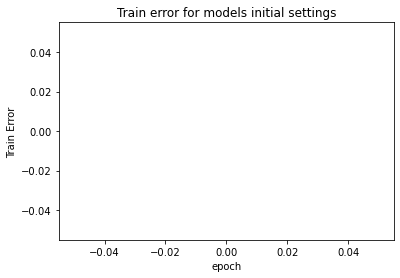

In [37]:
#plt the train error of model
plt.plot(model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')
plt.title("Train error for models initial settings")
plt.show()

## hyperparameter tuning

### for the gradient descent algorithm

In [38]:
models = []
methods = ["Adam","RMSprop"]

In [39]:
for method in methods:
    model = WideandDeepNet(
        wide_dim,
        embeddings_input,
        continuous_cols,
        deep_column_idx,
        hidden_layers,
        dropout,
        encoding_dict,
        n_class)
    model.compile(optimizer=method)
    if use_cuda:
        model = model.cuda()
    model.fit(dataset=train_dataset, n_epochs=5, batch_size=60)
    models.append(model)

Epoch 1 of 5, Loss: nan
Epoch 2 of 5, Loss: nan
Epoch 3 of 5, Loss: nan
Epoch 4 of 5, Loss: nan
Epoch 5 of 5, Loss: nan
Epoch 1 of 5, Loss: nan
Epoch 2 of 5, Loss: nan
Epoch 3 of 5, Loss: nan
Epoch 4 of 5, Loss: nan
Epoch 5 of 5, Loss: nan


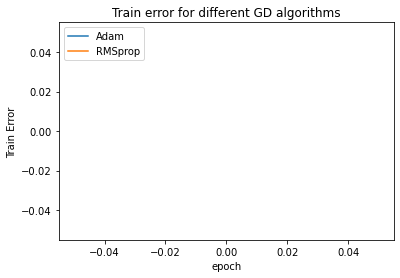

In [40]:
for model in models:
    plt.plot(np.arange(5),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.legend(methods, loc='upper left')
plt.title("Train error for different GD algorithms")
plt.show()

In [42]:
for model in models:
    print("for "+ str(model.optimizer))
    y_pred = model.predict(dataset=test_dataset)
    y = test_dataset.labels
    # print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
    # print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

for Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
for RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)


### optimizing dropout values

In [ ]:
droupouts = [0,0.1,0.5]
models_dropout=[]

In [ ]:
for droupout in droupouts:
    dropout = [droupout,droupout]
    model = WideandDeepNet(
        wide_dim,
        embeddings_input,
        continuous_cols,
        deep_column_idx,
        hidden_layers,
        dropout,
        encoding_dict,
        n_class)
    model.compile(optimizer="Adam")
    if use_cuda:
        model = model.cuda()
    model.fit(dataset=train_dataset, n_epochs=3, batch_size=60)
    models_dropout.append(model)

Epoch 1 of 3, Loss: 0.686
Epoch 2 of 3, Loss: 3.3
Epoch 3 of 3, Loss: 1.797
Epoch 1 of 3, Loss: 2.098
Epoch 2 of 3, Loss: 0.771
Epoch 3 of 3, Loss: 4.375
Epoch 1 of 3, Loss: 1.159
Epoch 2 of 3, Loss: 0.724
Epoch 3 of 3, Loss: 1.163


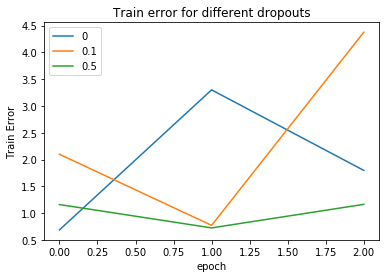

In [ ]:
for model in models_dropout:
    plt.plot(np.arange(3),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.legend(droupouts, loc='upper left')
plt.title("Train error for different dropouts")
plt.show()

In [ ]:
for model in models_dropout:
    print("for drououts: "+ str(model.dropout))
    y_pred = model.predict(dataset=test_dataset)
    y = test_dataset.labels
    print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
    print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

for drououts: [0, 0]
test mean squared error: 1.327298705029263
test mean absolute error: 0.9674445709737696
for drououts: [0.1, 0.1]
test mean squared error: 1.4589379506428217
test mean absolute error: 1.003326960903818
for drououts: [0.5, 0.5]
test mean squared error: 1.3582297251538353
test mean absolute error: 0.9704529255707942


## Evaluating the model with optimal hyperparameters

In [ ]:
dropout = [0.5,0.5]
model = WideandDeepNet(
    wide_dim,
    embeddings_input,
    continuous_cols,
    deep_column_idx,
    hidden_layers,
    dropout,
    encoding_dict,
    n_class)
model.compile(optimizer="Adam")
if use_cuda:
    model = model.cuda()
model.fit(dataset=train_dataset, n_epochs=10, batch_size=60)

Epoch 1 of 10, Loss: 2.669
Epoch 2 of 10, Loss: 0.893
Epoch 3 of 10, Loss: 2.157
Epoch 4 of 10, Loss: 1.586
Epoch 5 of 10, Loss: 1.628
Epoch 6 of 10, Loss: 1.359
Epoch 7 of 10, Loss: 0.64
Epoch 8 of 10, Loss: 2.361
Epoch 9 of 10, Loss: 1.098
Epoch 10 of 10, Loss: 2.597


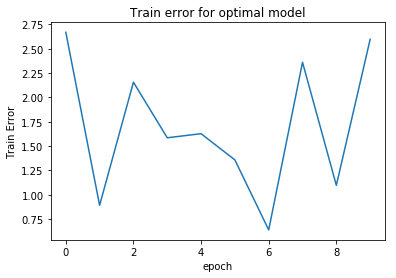

In [ ]:
plt.plot(np.arange(10),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.title("Train error for optimal model")
plt.show()

In [ ]:
y_pred = model.predict(dataset=test_dataset)
y = test_dataset.labels
print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

test mean squared error: 1.3538917806265323
test mean absolute error: 0.9229052796107362


### calcualte the time to run the model for different subsets

In [ ]:
unique_users = final_df['userId'].unique()
user_quantiles = np.arange(0.1,1,0.1)
runtimes = []

In [ ]:
import time
for quantile in user_quantiles:
    start_time = time.time()
    subset_users = unique_users[:int(len(unique_users)*quantile)]
    subset_df = final_df.loc[final_df['userId'].isin(subset_users)]
    data_processed = data_processing(
        subset_df, wide_cols,
        embeddings_cols,
        continuous_cols,
        target,
        scale=True)
    model = WideandDeepNet(
        wide_dim,
        embeddings_input,
        continuous_cols,
        deep_column_idx,
        hidden_layers,
        dropout,
        encoding_dict,
        n_class)
    model.compile(optimizer='Adam')
    if use_cuda:
        model = model.cuda()
    train_dataset = data_processed['train_dataset']
    model.fit(dataset=train_dataset, n_epochs=1, batch_size=60)
    end_time = time.time()
    total_time = end_time- start_time
    print("total time:" + str(total_time))
    runtimes.append(total_time)
    

/home/roxor/bin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1 of 1, Loss: 0.329
total time:2.0968427658081055
Epoch 1 of 1, Loss: 0.713
total time:4.748933792114258
Epoch 1 of 1, Loss: 0.85
total time:6.54540753364563
Epoch 1 of 1, Loss: 1.187
total time:9.715687036514282
Epoch 1 of 1, Loss: 1.218
total time:11.353285074234009
Epoch 1 of 1, Loss: 0.659
total time:13.029703378677368
Epoch 1 of 1, Loss: 0.407
total time:15.628254652023315
Epoch 1 of 1, Loss: 1.535
total time:17.98717498779297
Epoch 1 of 1, Loss: 2.209
total time:20.148995876312256


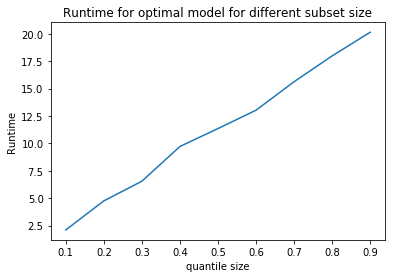

In [ ]:
plt.plot(user_quantiles,runtimes)
plt.ylabel('Runtime')
plt.xlabel('quantile size')

plt.title("Runtime for optimal model for different subset size")
plt.show()